# C3D NEURAL NETWORK
## VISUALIZE: Filters and Feature Maps for convolutional layers

This notebook can be used to visualize the filters and the feature maps of any convolutional layer of the C3D.  
To visualize a filter, you must choose a convolutional layer (conv1, conv2, conv3a, conv3b, conv4a, conv4b, conv5a, conv5b) and the numbers of the input unit and the output unit that are connected by the filter. These variables must be specified in the `plot_filter(conv_selected, input_u, output_u)` function.

To visualize a feature map, you must choose a video, copy its path in the `video_path` variable. Then you may select a clip of 16 frames or let the script choose it randomly. Then you must decide which frame among the 16 frames you want to use, which convolutional layer and which unit in this layer you prefer. These variables must be specified in the `plot_featmap(conv_selected,num_frame, num_unit)` function.

In [1]:
# PATHS: video_path, cfg.filter_path

In [9]:
import numpy as np
import os
import random
from matplotlib import pyplot

from utils.visualization_util import *
from c3d import *
import configuration as cfg

from PIL import Image
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

## How to visualize FILTERS

1. Choose the convolutional layer you want  
2. Chosse which filter you want to plot
![schema](./Filters_FeatureMaps/schema.png)

In [3]:
# Initialize the model
model = C3D() 

# Summarize layers' names and positions 
for i in range(len(model.layers)):
    if 'conv' not in model.layers[i].name:
        print("- ", i, model.layers[i].name)
    else: 
        filters, biases = model.layers[i].get_weights()
        print("- ", i, model.layers[i].name, filters.shape)
        # Filters.shape = [filter_depth, filter_height, filter_width, in_channels, out_channels]

    
# Save in a dict only convolutional layers and their positions 
positions_conv = {model.layers[i].name:i for i in range(len(model.layers)) if 'conv' in model.layers[i].name}

def plot_filter(conv_selected, input_u, output_u):
    '''Choose a conv layer and which filter you want to visualize'''
    if conv_selected not in positions_conv.keys():
        raise("Select a convolutional layer!")
    else: 
        posit = positions_conv[conv_selected]
        filters, biases = model.layers[posit].get_weights()
        f_min, f_max = filters.min(), filters.max()
        filters = (filters - f_min) / (f_max - f_min)
        
        tot_filters = filters.shape[-2]*filters.shape[-1]
        tot_units = filters.shape[-1]
        print('')
        print('Selected layer: {} with {} units (hence {} filters)'.format(conv_selected,tot_units,tot_filters))
        plt.imshow(filters[:, :, :, input_u, output_u])
        plt.axis('off')
        plt.title('{} layer: {}-{} filter'.format(conv_selected,input_u, output_u))
        plt.show()

-  0 conv1 (3, 3, 3, 3, 64)
-  1 pool1
-  2 conv2 (3, 3, 3, 64, 128)
-  3 pool2
-  4 conv3a (3, 3, 3, 128, 256)
-  5 conv3b (3, 3, 3, 256, 256)
-  6 pool3
-  7 conv4a (3, 3, 3, 256, 512)
-  8 conv4b (3, 3, 3, 512, 512)
-  9 pool4
-  10 conv5a (3, 3, 3, 512, 512)
-  11 conv5b (3, 3, 3, 512, 512)
-  12 zero_padding3d
-  13 pool5
-  14 flatten
-  15 fc6
-  16 dropout
-  17 fc7
-  18 dropout_1
-  19 fc8



Selected layer: conv1 with 64 units (hence 192 filters)


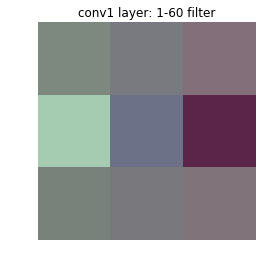

In [4]:
# Run the following cell to plot your filter 
plot_filter('conv1', 1, 60)

## How to visualize FEATURE MAPS 
The idea of visualizing a feature map for a specific input, that in our case is a clip of 16 frames, would be to understand what features of the input are detected or preserved in the feature maps.

In [5]:
# Select a video 
video_path = './Input/Caliano_2.mp4'
clips, frames = get_video_clips(video_path)
print('This video has {} frames, grouped into {} 16-frames-length clips'.format(frames, len(clips)))

# Select one clip for the visualization 
#num_clip = 10

# Or randomly select a clip to visualize
num_clip = np.random.randint(len(clips))
print('Selected clip: {}'.format(num_clip))

clip = np.array(clips[num_clip])
assert clip.shape == (16, 240, 320, 3)

# Save in a folder the 16 frames of the selected clip
name_output_folder = 'clips_{}__{}'.format(len(clips), os.path.basename(video_path).split('.')[0])
path_output_folder = os.path.join(cfg.filter_path, name_output_folder)
if not os.path.exists(path_output_folder):
    os.makedirs(path_output_folder)
c = 0
for i in clip:
    im = Image.fromarray(i)
    im.save(os.path.join(path_output_folder, 'clip_{}_{}.jpg'.format(c, len(clips))))
    c +=1
    
# Upload 16 frames and reshape them (112x112)
clipp = [] # list of 16 images
for i in range(16):
    clipp.append(load_img(os.path.join(path_output_folder, 'clip_{}_{}.jpg'.format(i, len(clips))),
                          target_size=(112, 112)))

clip_array = [] # list of 16 arrays
for i in range(len(clipp)):
    clip_array.append(img_to_array(clipp[i]))

clip_array = np.array(clip_array)
assert clip_array.shape == (16, 112, 112, 3)
clip_expanded = np.expand_dims(clip_array, axis=0)

This video has 1413 frames, grouped into 89 16-frames-length clips
Selected clip: 39


In [6]:
# Summarize Feature Maps shape per each layer 
for i in range(len(model.layers)):
    layer = model.layers[i]
    if 'conv' not in layer.name:
        continue
    print('-', i, layer.name, layer.output.shape)

- 0 conv1 (None, 16, 112, 112, 64)
- 2 conv2 (None, 16, 56, 56, 128)
- 4 conv3a (None, 8, 28, 28, 256)
- 5 conv3b (None, 8, 28, 28, 256)
- 7 conv4a (None, 4, 14, 14, 512)
- 8 conv4b (None, 4, 14, 14, 512)
- 10 conv5a (None, 2, 7, 7, 512)
- 11 conv5b (None, 2, 7, 7, 512)


In [7]:
 def plot_featmap(conv_selected,num_frame, num_unit):
        '''Select the convolutional layer, one frame of the clip and the unit of the layer'''
        if conv_selected not in positions_conv.keys():
            raise("Select a convolutional layer!")
        else: 
            posit = positions_conv[conv_selected]
            model_mini = Model(inputs=model.inputs, outputs=model.layers[posit].output)
            feature_maps = model_mini.predict(clip_expanded)
            print(feature_maps.shape)
            print('')
            print('Selected layer: {}'.format(conv_selected))
            plt.imshow(feature_maps[0, num_frame, :, :, num_unit], cmap='CMRmap')
            plt.axis('off')
            plt.title('{} layer: frame {} - unit {}'.format(conv_selected,num_frame, num_unit))
            plt.show()
            return feature_maps

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(1, 16, 112, 112, 64)

Selected layer: conv1


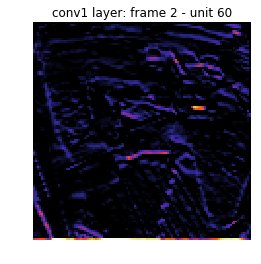

In [8]:
feature_maps = plot_featmap('conv1', 2, 60)